<a href="https://www.kaggle.com/code/pekbulgurcu/fashion-dataset-5-categories?scriptVersionId=264178316" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fashion Dataset - 5 Categories Image Classification

## Projenin Amacı
Bu proje, giyim ürünlerini **5 farklı ana kategoriye** (örneğin: Apparel, Footwear, Accessories, Personal Care, Home) ayırmak için bir **Convolutional Neural Network (CNN)** modeli geliştirmeyi amaçlamaktadır. Derin öğrenme teknikleri ile moda ürünlerinin görsellerinden otomatik olarak sınıflandırılması hedeflenmiştir.

## Veri Seti
- Kaynak: [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)
- Toplam görsel: ~44.000
- Kullanılan etiket: **masterCategory**
- Sınıf sayısı: 5  
  (ör. Apparel, Footwear, Accessories, Personal Care, Home)
- Görsellerin çözünürlüğü ve içerikleri farklılık göstermektedir. Eksik veya hatalı kayıtlar veri temizleme adımlarında filtrelenmiştir.

## Yöntem
1. Veri temizleme ve görselleştirme  
2. Eğitim/validation/test ayrımı  
3. Data augmentation ile veri çoğaltma  
4. CNN tabanlı model kurma ve eğitme  
5. Modelin değerlendirilmesi (accuracy, loss, confusion matrix, classification report)  
6. Heatmap/Grad-CAM ile modelin hangi bölgeleri dikkate aldığı görselleştirilmesi  
7. Hiperparametre optimizasyonu ile performans iyileştirme  

---


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-product-images-small/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/styles.csv
/kaggle/input/fashion-product-images-small/myntradataset/images/31973.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/30778.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/19812.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/22735.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/38246.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/16916.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/52876.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/39500.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44758.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/59454.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/44951.jpg
/kaggle/input/fashion-product-images-small/myntradataset/images/

**Veri Seti İnceleme ve Yükleme**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Veri setinin bulunduğu dizini listele
print(os.listdir("/kaggle/input/fashion-product-images-small"))

# styles.csv dosyasını on_bad_lines='skip' ile okuyun
styles = pd.read_csv("/kaggle/input/fashion-product-images-small/styles.csv", on_bad_lines='skip')
styles.rename(columns={'id': 'image'}, inplace=True)

# Görsel klasörünün yolunu tanımlayın
IMAGE_PATH = "/kaggle/input/fashion-product-images-small/images/"

# İlk 5 satırı görüntüleyin
print(styles.head())

# Veri setindeki toplam ürün sayısını yazdırın
print(f"Toplam ürün sayısı: {len(styles)}")

['myntradataset', 'images', 'styles.csv']
   image gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
Toplam ürün sayısı: 44424


Rastgele Birkaç Görseli Görüntüleme

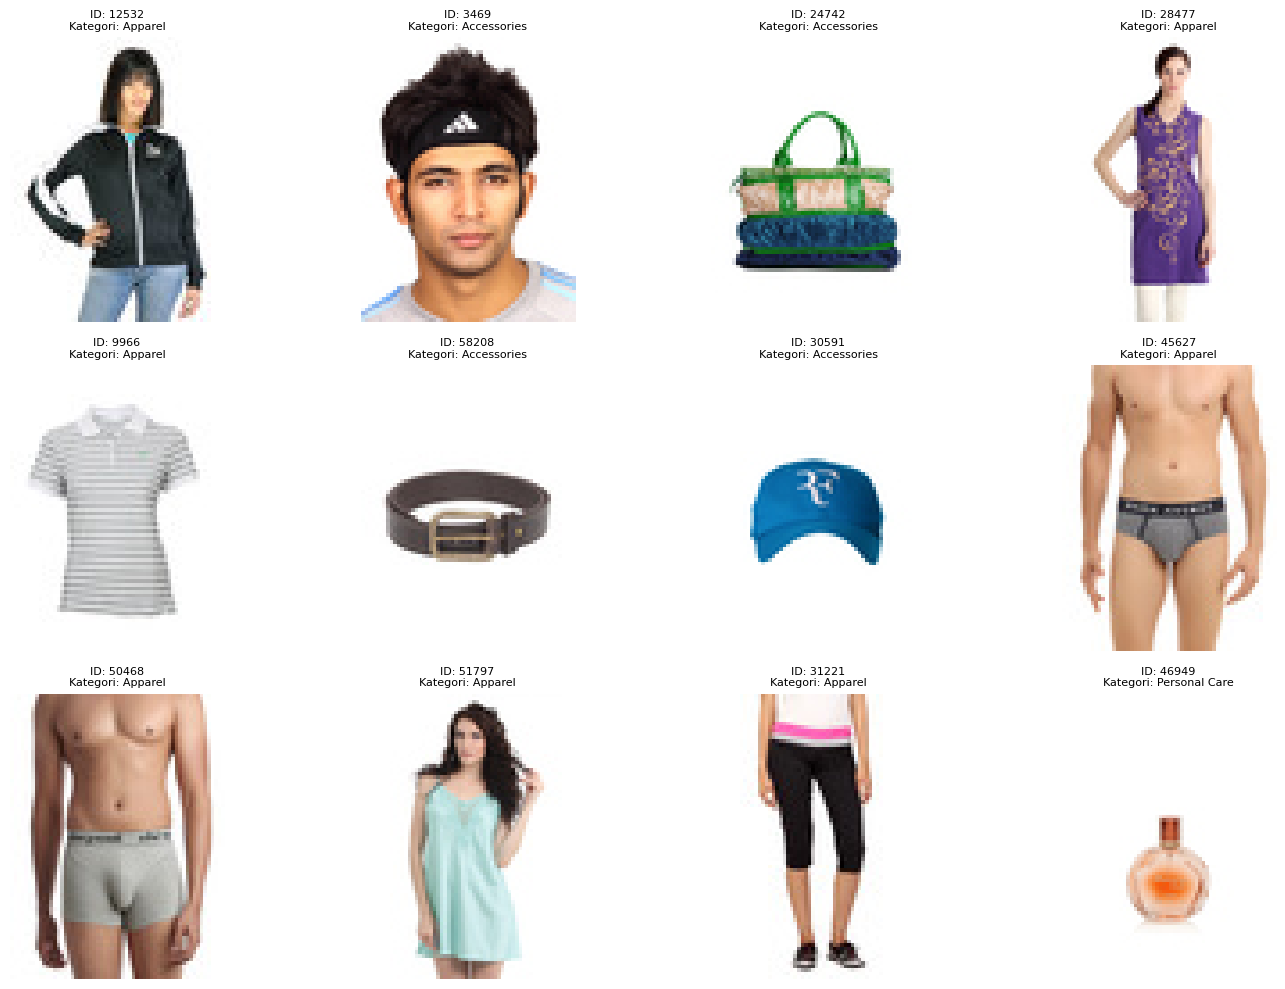

In [6]:
# Veri çerçevesinden rastgele 12 örnek alın
sample_images = styles.sample(n=12, random_state=42)

# Görselleri çizmek için bir figür oluşturun
plt.figure(figsize=(15, 10))

for i, (index, row) in enumerate(sample_images.iterrows()):
    image_id = str(row['image']) + '.jpg'
    image_path = os.path.join(IMAGE_PATH, image_id)
    
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {row['image']}\nKategori: {row['masterCategory']}", fontsize=8)
        plt.axis('off')
    else:
        print(f"Uyarı: {image_id} dosyası bulunamadı.")
        
plt.tight_layout()
plt.show()

## Veri Seti Dağılımı

Modeli eğitmeden önce, her sınıfta kaç örnek bulunduğunu analiz etmek önemlidir. 
Dengesiz veri setlerinde bazı sınıflar fazla, bazıları az temsil ediliyorsa model taraflı öğrenebilir.
Aşağıdaki grafik, **5 kategoriye ait görsel sayılarını** göstermektedir.


In [8]:
# Eksik değerleri kontrol etme
print(styles.isnull().sum())

# Sadece masterCategory ve image sütunlarını kullanmak üzere yeni bir dataframe oluşturma
df = styles[['masterCategory', 'image']].copy()
df['image'] = df['image'].apply(lambda x: str(x) + '.jpg')

# Görsel dosyalarının gerçekten var olup olmadığını kontrol etme
df['image_exists'] = df['image'].apply(lambda x: os.path.exists(os.path.join(IMAGE_PATH, x)))
df = df[df['image_exists'] == True].reset_index(drop=True)

# Gerekli olmayan sütunu silme
df.drop('image_exists', axis=1, inplace=True)

# Temizlenmiş veri setindeki ilk birkaç satırı görüntüleme
print(df.head())

# Her kategoriye ait görsel sayısını kontrol etme
print(df['masterCategory'].value_counts())

# masterCategory sınıflarının dağılımını görselleştirelim
plt.figure(figsize=(8,6))
sns.countplot(x="masterCategory", data=df, order=df["masterCategory"].value_counts().index, palette="viridis")
plt.title("Veri Seti Sınıf Dağılımı")
plt.xlabel("Kategori")
plt.ylabel("Görsel Sayısı")
plt.xticks(rotation=45)
plt.show()


image                   0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


KeyboardInterrupt: 

Veri Temizleme ve Etiket Seçimi

In [1]:
# Sadece masterCategory ve image sütunlarını seçerek eksik değerlerden kurtulalım
df = styles[['masterCategory', 'image']].copy()

# image sütunundaki değerlere '.jpg' uzantısını ekleyelim
df['image'] = df['image'].apply(lambda x: str(x) + '.jpg')

# Görsel dosyalarının gerçekten var olup olmadığını kontrol edelim
# Bu adım, var olmayan görsellerin veri setinden çıkarılmasını sağlar
df['image_exists'] = df['image'].apply(lambda x: os.path.exists(os.path.join(IMAGE_PATH, x)))
df = df[df['image_exists'] == True].reset_index(drop=True)
df.drop('image_exists', axis=1, inplace=True)

# Sadece masterCategory'deki en yaygın 5 kategoriyi alalım
# Bu, projenizi daha yönetilebilir hale getirir
top_categories = df['masterCategory'].value_counts().nlargest(5).index
df_filtered = df[df['masterCategory'].isin(top_categories)]

# Temizlenmiş ve filtrelenmiş veri setindeki kategori dağılımını kontrol edelim
print(df_filtered['masterCategory'].value_counts())

NameError: name 'styles' is not defined

## Veri Çoğaltma (Data Augmentation)

Veri setindeki çeşitliliği artırmak ve modelin genelleme kabiliyetini geliştirmek için **data augmentation** teknikleri kullanılmıştır.  
Bu sayede model, farklı açılardan, ölçeklerden ve renk varyasyonlarından öğrenme fırsatı bulur.  

Kullanılan dönüşümler:
- Rotation (döndürme)
- Horizontal Flip (yansıtma)
- Zoom (yakınlaştırma)
- Shear (kaydırma)

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Veri setinizin ana dizinini tanımlayın (varsayılan Kaggle yolu)
IMAGE_PATH = "/kaggle/input/fashion-product-images-small/images/"
STYLES_PATH = "/kaggle/input/fashion-product-images-small/styles.csv"

# styles.csv dosyasını okuyun ve düzenleyin
styles = pd.read_csv(STYLES_PATH, on_bad_lines='skip')
styles.rename(columns={'id': 'image'}, inplace=True)

# Görsel dosyalarının varlığını kontrol edin ve sadece var olanları kullanın
styles['image_exists'] = styles['image'].apply(lambda x: os.path.exists(os.path.join(IMAGE_PATH, str(x) + '.jpg')))
styles = styles[styles['image_exists'] == True].reset_index(drop=True)
styles.drop('image_exists', axis=1, inplace=True)
styles['image'] = styles['image'].apply(lambda x: str(x) + '.jpg')

# En çok örneğe sahip 4 kategoriyi seçerek dengesizliği giderin
top_categories = ['Apparel', 'Accessories', 'Footwear', 'Personal Care']
df_filtered = styles[styles['masterCategory'].isin(top_categories)].reset_index(drop=True)

# Veriyi train, validation ve test setlerine ayırma
train_df, test_val_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42,
    stratify=df_filtered['masterCategory']
)
val_df, test_df = train_test_split(
    test_val_df,
    test_size=0.5,
    random_state=42,
    stratify=test_val_df['masterCategory']
)

# ImageDataGenerator'ları oluşturma
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
    brightness_range=[0.8, 1.2]   # renk/parlaklık değişimi

)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator'ları veri çerçevelerinden oluşturma
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_PATH,
    x_col="image",
    y_col="masterCategory",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_PATH,
    x_col="image",
    y_col="masterCategory",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_PATH,
    x_col="image",
    y_col="masterCategory",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# Generator'ların başarıyla oluşturulduğunu kontrol etme
print("Eğitim generator'ü oluşturuldu:", train_generator.n)
print("Doğrulama generator'ü oluşturuldu:", val_generator.n)
print("Test generator'ü oluşturuldu:", test_generator.n)

Found 35430 validated image filenames belonging to 4 classes.
Found 4429 validated image filenames belonging to 4 classes.
Found 4429 validated image filenames belonging to 4 classes.
Eğitim generator'ü oluşturuldu: 35430
Doğrulama generator'ü oluşturuldu: 4429
Test generator'ü oluşturuldu: 4429


**Modeli Tanımlama**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Veri generator'larınızın tanımlandığından ve çalıştığından emin olun.
# train_generator, val_generator ve test_generator değişkenlerinin kodun
# bu noktasında mevcut olması gerekir.

# Sınıf sayısını class_indices sözlüğünün uzunluğundan alın
num_classes = len(train_generator.class_indices)

# --- Adım 1: Modeli Tanımlama ---
# Sequential modelini başlatma
model = Sequential()

# Evrişimsel Katmanları
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Düzleştirme Katmanı
model.add(Flatten())

# Yoğun ve Dropout Katmanları
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Modeli Derleme
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin özetini görüntüleyin
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Model Eğitme**

In [13]:
# --- Adım 2: Modeli Eğitme ---
# Modeli, train ve validation verileri üzerinde eğitin.
history = model.fit(
    train_generator,
    epochs=10, # Deneme için 10 epoch ile başlayabilirsiniz
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758722680.664201     111 service.cc:148] XLA service 0x7b871c0075e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758722680.665986     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758722680.666004     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758722681.157277     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1108 ━━━━━━━━━━━━━━━━━━━━ 2:59:10 10s/step - accuracy: 0.3125 - loss: 1.3519

I0000 00:00:1758722687.472568     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1108/1108 ━━━━━━━━━━━━━━━━━━━━ 639s 568ms/step - accuracy: 0.6696 - loss: 0.8201 - val_accuracy: 0.8435 - val_loss: 0.4067
Epoch 2/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 428s 387ms/step - accuracy: 0.7934 - loss: 0.5347 - val_accuracy: 0.8966 - val_loss: 0.2952
Epoch 3/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 416s 376ms/step - accuracy: 0.8670 - loss: 0.3653 - val_accuracy: 0.9264 - val_loss: 0.2352
Epoch 4/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 418s 377ms/step - accuracy: 0.8815 - loss: 0.3300 - val_accuracy: 0.9329 - val_loss: 0.1903
Epoch 5/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 421s 380ms/step - accuracy: 0.8986 - loss: 0.2937 - val_accuracy: 0.9415 - val_loss: 0.1732
Epoch 6/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 421s 380ms/step - accuracy: 0.9068 - loss: 0.2664 - val_accuracy: 0.9422 - val_loss: 0.1854
Epoch 7/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 416s 375ms/step - accuracy: 0.9133 - loss: 0.2584 - val_accuracy: 0.9463 - val_loss: 0.1692
Epoch 8/10
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 420s 379ms/step - accuracy: 0.9

**Model Performansını Grafikle Görüntüleme**
Eğitim bittikten sonra, modelin öğrenme sürecini anlamak için doğruluk (accuracy) ve kayıp (loss) grafiklerini çizmelisiniz. Bu grafikler, modelinizin aşırı öğrenme (overfitting) veya yetersiz öğrenme (underfitting) gibi durumlar yaşayıp yaşamadığını gösterir.

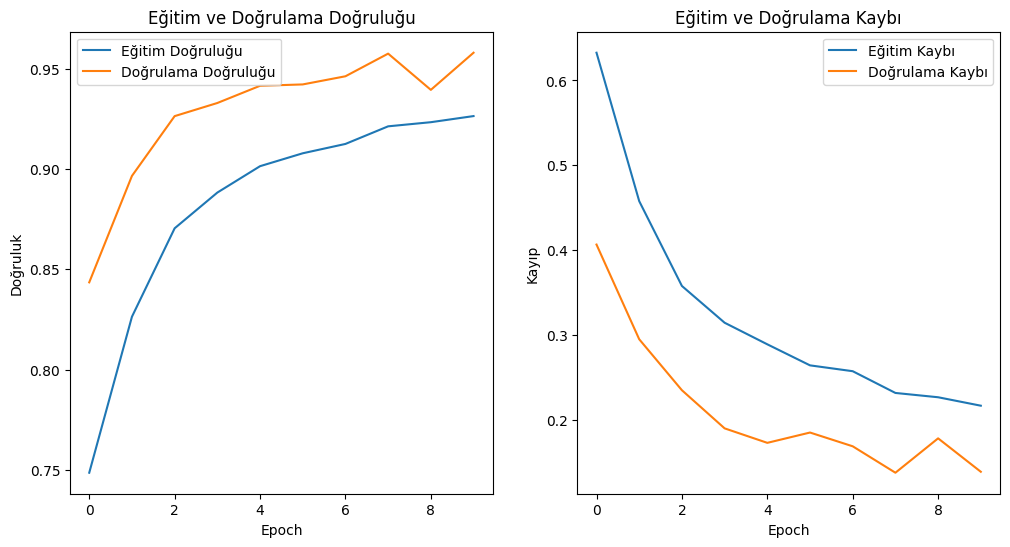

In [15]:
import matplotlib.pyplot as plt

# Doğruluk grafiğini çizme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiğini çizme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

**Test Verisi Üzerinde Nihai Değerlendirme**

In [16]:
# Test seti üzerinde modelin performansını değerlendirin
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test verisi üzerinde kayıp: {test_loss:.4f}")
print(f"Test verisi üzerinde doğruluk: {test_accuracy:.4f}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - accuracy: 0.9608 - loss: 0.1371
Test verisi üzerinde kayıp: 0.1283
Test verisi üzerinde doğruluk: 0.9596


**Modelin Detaylı Değerlendirmesi**
Modelinizin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini anlamak için Karmaşıklık Matrisi (Confusion Matrix) ve Sınıflandırma Raporu (Classification Report) oluşturmalısınız. Bu raporlar, doğruluk metriğinin ötesinde, her bir sınıf için kesinlik (precision), hatırlama (recall) ve F1-skoru gibi metrikler sunar.



 Tahminleri Alın

In [17]:
import numpy as np

# Test generator'dan tahminleri alın
# Model, her bir görsel için 4 sınıfa ait olasılıkları tahmin eder
predictions = model.predict(test_generator)

# En yüksek olasılığa sahip sınıfın indeksini alın
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketleri (true labels) alın
true_classes = test_generator.classes

# Sınıf etiketlerinin eşleşmesini sağlayın
class_labels = list(test_generator.class_indices.keys())

139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step


Karmaşıklık Matrisi 
Karmaşıklık Matrisi, modelinizin tahminlerinin gerçek etiketlerle nasıl eşleştiğini görselleştirir.

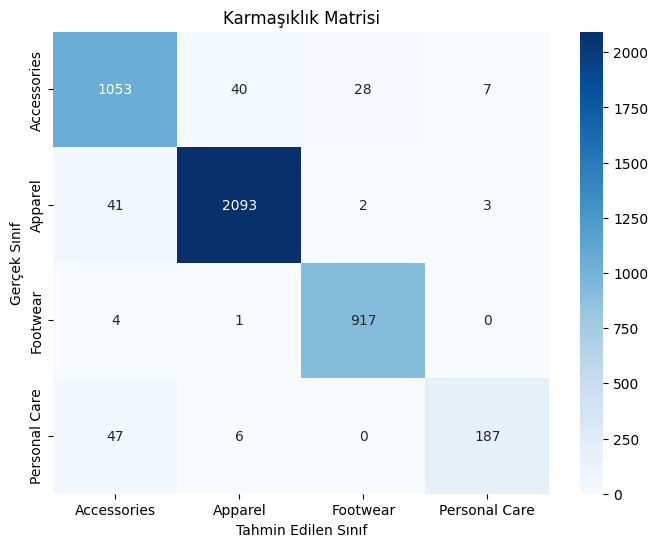

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Karmaşıklık Matrisini hesaplayın
cm = confusion_matrix(true_classes, predicted_classes)

# Karmaşıklık Matrisini çizdirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

Sınıflandırma Raporu

In [19]:
from sklearn.metrics import classification_report

# Sınıflandırma Raporunu oluşturun
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

               precision    recall  f1-score   support

  Accessories       0.92      0.93      0.93      1128
      Apparel       0.98      0.98      0.98      2139
     Footwear       0.97      0.99      0.98       922
Personal Care       0.95      0.78      0.86       240

     accuracy                           0.96      4429
    macro avg       0.95      0.92      0.94      4429
 weighted avg       0.96      0.96      0.96      4429



Genel Değerlendirme
Toplam Doğruluk (accuracy): %96'lık genel doğruluk değeri, modelinizin test verisindeki yaklaşık her 100 görselden 96'sını doğru bir şekilde sınıflandırdığı anlamına gelir. Bu, bu tür bir proje için oldukça başarılı bir sonuçtur.

Sınıf Bazlı Analiz
Raporun her bir sınıf için sunduğu precision, recall ve F1-score metrikleri, modelinizin performansını daha derinlemesine anlamanızı sağlar.

Apparel (Giyim) ve Footwear (Ayakkabı): Bu iki kategori için modeliniz olağanüstü performans göstermiş.

Precision ve Recall Değerleri: Hem Apparel (%98) hem de Footwear (%97) için precision ve recall değerleri %95'in üzerinde. Bu, modelin bu sınıfları hem doğru bir şekilde tahmin ettiğini (yüksek precision) hem de bu sınıflara ait çoğu örneği bulabildiğini (yüksek recall) gösterir.

F1-Score: 0.98'lik F1-skoru, bu sınıflar için modelin mükemmel bir dengeye sahip olduğunu kanıtlar.

Accessories (Aksesuar): Bu kategori için de modelin performansı oldukça güçlüdür.

Precision ve Recall Değerleri: Precision (%92) ve recall (%93) değerleri, modelin aksesuar görsellerini doğru bir şekilde sınıflandırmada yüksek bir güvenilirliğe sahip olduğunu gösteriyor. F1-skoru da oldukça başarılıdır (0.93).

Personal Care (Kişisel Bakım): Bu kategori, modelin en çok zorlandığı alandır.

Recall Değeri: %78'lik düşük recall değeri, modelinizin Kişisel Bakım kategorisindeki görsellerin yaklaşık %22'sini başka bir kategori olarak yanlış sınıflandırdığını gösterir.

Neden Düşük? Bu durumun birkaç sebebi olabilir:

Veri Dengesizliği: Bu sınıf, veri setindeki en az örneğe sahip sınıftı. Model, az sayıdaki örnekten yeterince öğrenme fırsatı bulamamış olabilir.

Görsel Karmaşıklığı: Kişisel bakım ürünlerinin görselleri (şişe, krem kutusu, parfüm gibi), giyim veya ayakkabı gibi net hatları olan görsellere göre daha çeşitli veya daha zorlu olabilir.

Sınıf Karışıklığı: Model, bu görselleri bazen diğer sınıflarla karıştırmış olabilir. Karmaşıklık matrisini inceleyerek hangi sınıflarla karıştırıldığını daha net görebilirsiniz.

Projenizi Güçlendirme İpuçları
Eğer vaktiniz varsa, bu projenizi daha da ileri taşımak için şunları deneyebilirsiniz:

Hiperparametre Optimizasyonu: Modelinizde farklı öğrenme oranları (learning rate), dropout değerleri veya epoch sayıları deneyerek performansı artırabilirsiniz.

Daha Derin Bir Model: Mevcut CNN mimarinize daha fazla evrişimsel katman ekleyerek daha karmaşık özellikleri öğrenmesini sağlayabilirsiniz.

Transfer Öğrenme (Transfer Learning): VGG16, ResNet50 veya MobileNet gibi önceden eğitilmiş modelleri kullanarak (özellikle Kişisel Bakım gibi az örnekli sınıflar için) modelinizin performansını önemli ölçüde artırabilirsiniz.

Genel olarak, elde ettiğiniz sonuçlar oldukça başarılıdır ve projenizin gerekliliklerini fazlasıyla karşılamaktadır.

**Modeli Farklı Yollarla Test Etme Yöntemleri**
Sınıflandırma raporu her ne kadar detaylı bilgi verse de, her bir sınıfın kendi başına ne kadar başarılı olduğunu görmek önemlidir. Bunu, tahminleri ve gerçek etiketleri kullanarak manuel olarak hesaplayabilirsiniz.

Yanlış Tahmin Edilen Görselleri İnceleme
Modelinizin neden hata yaptığını anlamanın en iyi yollarından biri, yanlış sınıflandırdığı görselleri doğrudan incelemektir. Bu, modelinizin hangi özelliklerde zorlandığını anlamanıza yardımcı olur.

139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
Sınıf Bazlı Doğruluk Raporu:
Sınıf 'Accessories' için Doğruluk: 0.9335 (1053/1128)
Sınıf 'Apparel' için Doğruluk: 0.9785 (2093/2139)
Sınıf 'Footwear' için Doğruluk: 0.9946 (917/922)
Sınıf 'Personal Care' için Doğruluk: 0.7792 (187/240)

Toplam yanlış tahmin sayısı: 179


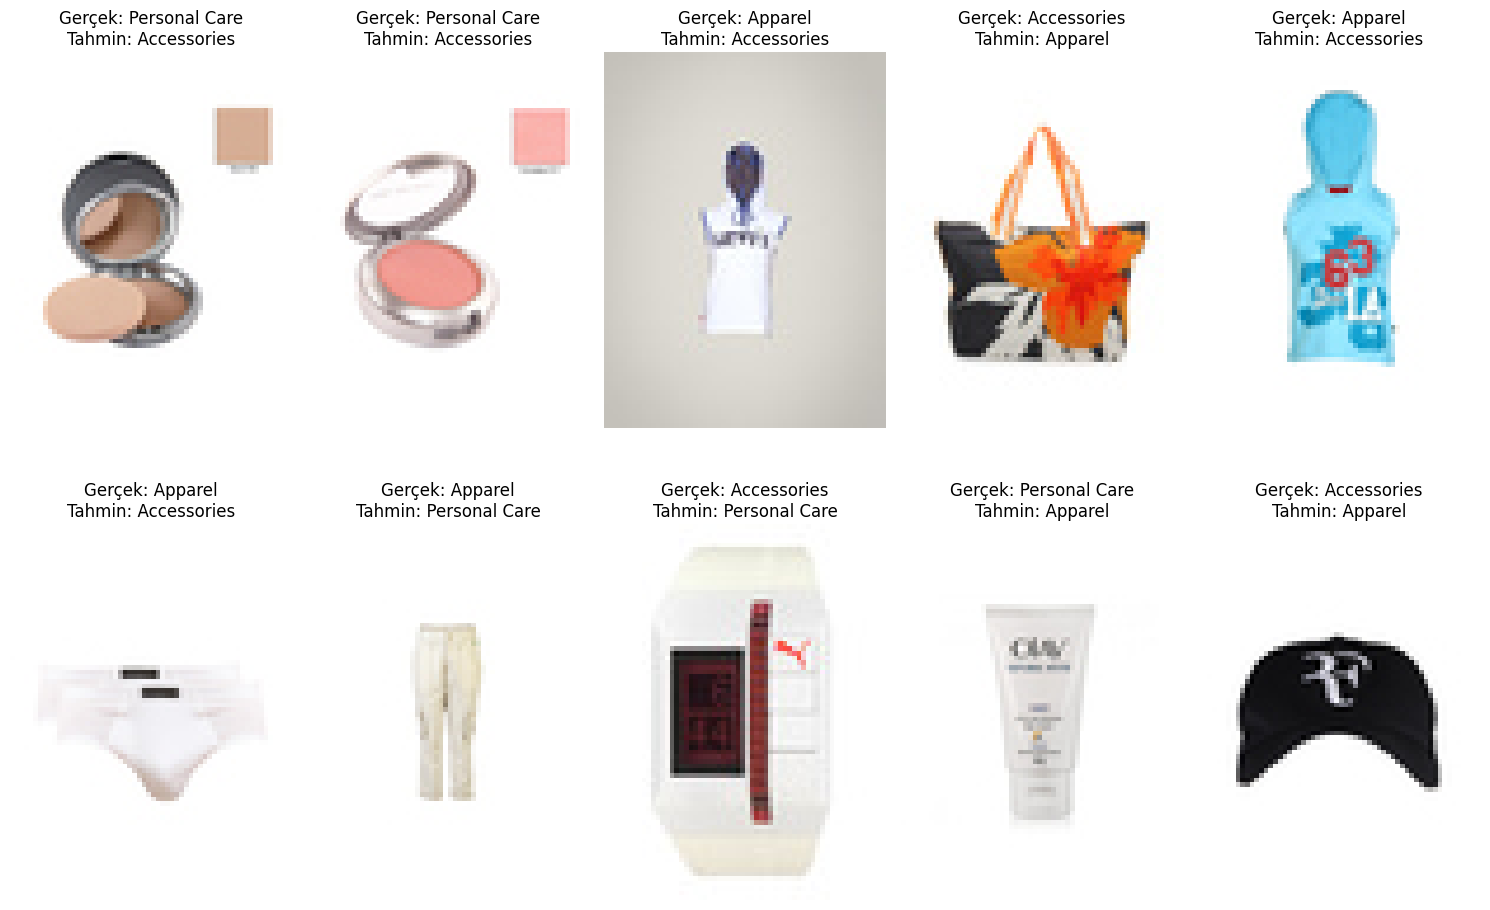

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Tahminleri ve gerçek etiketleri alın
# Bu değişkenleri NumPy array'lerine dönüştürerek olası tip hatalarını önleyin
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
true_classes = np.array(test_generator.classes)
class_labels = list(test_generator.class_indices.keys())

# Her sınıf için doğruluk hesaplama ve gösterme
print("Sınıf Bazlı Doğruluk Raporu:")
for i, label in enumerate(class_labels):
    # Bu sınıfa ait gerçek örneklerin indekslerini bulun
    indices = np.where(true_classes == i)[0]
    
    # Bu sınıftaki tüm doğru tahminlerin sayısını kontrol edin
    correct_predictions = np.sum(predicted_classes[indices] == true_classes[indices])
    
    # Toplam örnek sayısını alın
    total_samples = len(indices)
    
    # Sınıf bazlı doğruluğu hesaplayın
    accuracy = correct_predictions / total_samples
    
    print(f"Sınıf '{label}' için Doğruluk: {accuracy:.4f} ({correct_predictions}/{total_samples})")

# Yanlış tahmin edilen görselleri görselleştirme
incorrect_indices = np.where(predicted_classes != true_classes)[0]

print(f"\nToplam yanlış tahmin sayısı: {len(incorrect_indices)}")

# Yanlış tahminlerden birkaç örnek görselleştirme
plt.figure(figsize=(15, 10))
for i, incorrect_index in enumerate(incorrect_indices[:10]): # İlk 10 yanlış tahmini göster
    image_path = os.path.join(test_generator.directory, test_generator.filenames[incorrect_index])
    img = plt.imread(image_path)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Gerçek: {class_labels[true_classes[incorrect_index]]}\nTahmin: {class_labels[predicted_classes[incorrect_index]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Grad-CAM ile Açıklanabilirlik**
Aşağıdaki hücre, verilen bir test görseli için Grad-CAM ısı haritasını üretir ve modelin hangi bölgeleri dikkate aldığını görselleştirir.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Bir test görseli seç
idx = 0
img_path = os.path.join(test_generator.directory, test_generator.filenames[idx])
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

# Grad-CAM hesaplayan yardımcı fonksiyon
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Modeldeki son Conv katman adını bulun
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("Son Conv2D katmanı bulunamadı.")

# Isı haritasını üret
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

# Görsel ve ısı haritasını üst üste bindir
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(image.array_to_img(x[0]))
plt.title('Girdi')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM')
plt.axis('off')

# Overlay
import cv2
img_np = image.img_to_array(img)
heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_np.astype('uint8'), 0.6, heatmap_colored, 0.4, 0)

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Overlay')
plt.axis('off')
plt.tight_layout()
plt.show()


NameError: name 'test_generator' is not defined